# scCODA Power analysis

In [1]:
%matplotlib inline 

import sys
import numpy as np
import seaborn as sns
import pandas as pd
import rpy2.rinterface

import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

%load_ext rpy2.ipython

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
sns.set_style("ticks")
results_path = "../../sccoda_benchmark_data_review/overall_benchmark/"

## FDR 0.1

In [3]:
# read in aggregated benchmark results for power analysis 
df = pd.read_csv(results_path + "results_grouped_fdr_01.csv", sep=",")
df["log_increase"] = np.log(df["Increase"])
df["total_samples"] = df["n_controls"] + df["n_cases"]
df["log_total_samples"] = np.log(df["total_samples"])
df["ratio_case"] = df["n_cases"] / df["n_controls"]
df["mcc_scaled"] = (df["mcc"]  + 1)/2
df.head()

,Unnamed: 0,n_controls,n_cases,Base,Increase,log-fold increase,tp,tn,fp,fn,tpr,tnr,precision,fdr,accuracy,youden,f1_score,mcc,log_increase,total_samples,log_total_samples,ratio_case,mcc_scaled
0,0,1,1,20,10,0.58,0,40,0,10,0.0,1.000,0.0,0.0,0.8,0.000,0.000000,0.000000,2.302585,2,0.693147,1.0,0.500000
1,1,1,1,20,20,1.00,0,40,0,10,0.0,1.000,0.0,0.0,0.8,0.000,0.000000,0.000000,2.995732,2,0.693147,1.0,0.500000
2,2,1,1,20,30,1.32,0,40,0,10,0.0,1.000,0.0,0.0,0.8,0.000,0.000000,0.000000,3.401197,2,0.693147,1.0,0.500000
3,3,1,1,20,40,1.58,0,40,0,10,0.0,1.000,0.0,0.0,0.8,0.000,0.000000,0.000000,3.688879,2,0.693147,1.0,0.500000
4,4,1,1,20,50,1.81,1,39,1,9,0.1,0.975,0.5,0.5,0.8,0.075,0.166667,0.153093,3.912023,2,0.693147,1.0,0.576547


In [4]:
# calculate logit trasnform of scaled mcc values
mscale_min = np.min(df["tpr"])
df["tpr_trans"] = np.log( (df["tpr"]+0.0000001) / ((1-df["tpr"]+0.0000001))) 

In [5]:
df["tpr_trans"]

0       -16.118096
1       -16.118096
2       -16.118096
3       -16.118096
4        -2.197224
           ...    
14995    -0.847298
14996     2.197224
14997    16.118096
14998    16.118096
14999    16.118096
Name: tpr_trans, Length: 15000, dtype: float64

/Users/johannes.ostner/opt/anaconda3/envs/scCODA_2/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


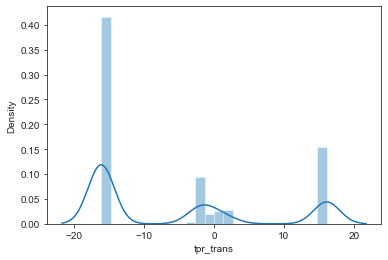

In [6]:
ax = sns.distplot(df["tpr_trans"])

/Users/johannes.ostner/opt/anaconda3/envs/scCODA_2/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


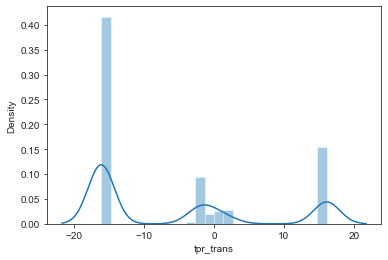

In [7]:
ax = sns.distplot(df["tpr_trans"])

/Users/johannes.ostner/opt/anaconda3/envs/scCODA_2/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


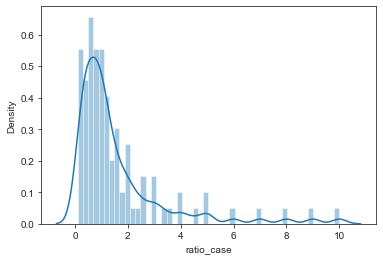

In [8]:
ax = sns.distplot(df["ratio_case"])

In [9]:
print(df.columns)

df = df[[ "tpr_trans",  "ratio_case",  "total_samples", "log-fold increase", "log_increase"]]
df.to_csv("./tpr_data_for_r_new_data.csv")

Index(['Unnamed: 0', 'n_controls', 'n_cases', 'Base', 'Increase',
       'log-fold increase', 'tp', 'tn', 'fp', 'fn', 'tpr', 'tnr', 'precision',
       'fdr', 'accuracy', 'youden', 'f1_score', 'mcc', 'log_increase',
       'total_samples', 'log_total_samples', 'ratio_case', 'mcc_scaled',
       'tpr_trans'],
      dtype='object')


In [10]:
%%R

# R cell regression analysis and backwards selection
library(caret)
library(leaps)

df = read.csv2("tpr_data_for_r_new_data.csv", sep=",", header = TRUE, dec = ".")
df <- df[-1]
df

train.control <- trainControl(method = "repeatedcv", number = 10, repeats=5)
# Train the model
step.model <- train(tpr_trans ~ (.)**2, 
                    data = df,
                    method = "leapBackward", 
                    tuneGrid = data.frame(nvmax = 1:4),
                    trControl = train.control
)
step.model$results
summary(step.model$finalModel)
coef(step.model$finalModel, step.model$bestTune[[1]])

R[write to console]: Loading required package: lattice

R[write to console]: Loading required package: ggplot2



                   (Intercept)                  total_samples 
                   -27.1649368                     -0.6618768 
                  log_increase     total_samples:log_increase 
                     2.6774452                      0.2469110 
log.fold.increase:log_increase 
                     0.5192467 


In [11]:
#python cell
from matplotlib import cm

def one_des_mcc(power, base, lf_inc, fdr=0.05):
    """ 
    quasibinomial regression directly on tpr
    
    calculates the number of required samples for 
    fixed MCC base increase and log-fold change using the fitted linear model
    
    step.model <- train(tpr ~ log.total  + log.fold.increase+ log.total:log.increase+log.increase:log.fold.increase, 
                        data = df3,
                        family=quasibinomial('logit'),
                        method = "glm", 
                        #tuneGrid = data.frame(nvmax = 1:4),
                        trControl = train.control
    )

    
    log_total_sample = -(a + b2 x2 + b4 x2 x3 - y)/(b1 + b3 x3)

    FDR 0.05
    ========
          nvmax      RMSE  Rsquared       MAE      RMSESD  RsquaredSD       MAESD
    1     1 0.2501995 0.6196052 0.1704546 0.004947534 0.015706285 0.003680543
    2     2 0.1968200 0.7646094 0.1597578 0.002748016 0.007057962 0.002278992
    3     3 0.1859121 0.7899321 0.1528826 0.003143411 0.007682132 0.002767555
    4     4 0.1794369 0.8043005 0.1435088 0.003606858 0.008577800 0.002846492
    5     5 0.1781367 0.8071405 0.1405079 0.003654164 0.008587321 0.002861529
    6     6 0.1781478 0.8071203 0.1405876 0.003626250 0.008521850 0.002838331
    

                       (Intercept)                      log.total 
                       -0.14044029                    -0.16678069 
                 log.fold.increase         log.total:log.increase 
                       -0.22374997                     0.06541749 
    log.increase:log.fold.increase 
                        0.05286727 
                        
                        
          parameter      RMSE  Rsquared        MAE      RMSESD  RsquaredSD       MAESD
    1      none 0.1013318 0.9374484 0.04944293 0.006237351 0.008033293 0.002772205

    Call:
    NULL

    Deviance Residuals: 
         Min        1Q    Median        3Q       Max  
    -2.44383  -0.16726  -0.05544   0.09365   1.63681  

    Coefficients:
                                     Estimate Std. Error t value Pr(>|t|)    
    (Intercept)                      -8.84886    0.26324 -33.615  < 2e-16 ***
    log.total                        -2.36269    0.18391 -12.847  < 2e-16 ***
    log.fold.increase                 0.30423    0.22163   1.373 0.169855    
    `log.total:log.increase`          0.96376    0.02818  34.199  < 2e-16 ***
    `log.fold.increase:log.increase`  0.13694    0.03899   3.512 0.000446 ***
    ---
                        
                        
    FDR 0.1
    =======
          nvmax      RMSE  Rsquared       MAE      RMSESD  RsquaredSD       MAESD
    1     1 0.2592998 0.6094817 0.1974915 0.003765617 0.011719968 0.014646427
    2     2 0.2002366 0.7671819 0.1626934 0.003099040 0.007373119 0.002861877
    3     3 0.1869059 0.7970950 0.1540439 0.002874103 0.006423662 0.002457849
    4     4 0.1838040 0.8038002 0.1485405 0.002984966 0.006527654 0.002542601
    5     5 0.1837587 0.8039079 0.1482092 0.002955405 0.006471140 0.002532354
    6     6 0.1837227 0.8039858 0.1480846 0.002956071 0.006469283 0.002538420
    
                           
                       (Intercept)                      log.total 
                       -0.11950939                    -0.19988348 
                 log.fold.increase         log.total:log.increase 
                       -0.15633159                     0.07211883 
    log.increase:log.fold.increase 
                        0.04186542
                        
                        
                        
                        
          parameter      RMSE  Rsquared        MAE      RMSESD  RsquaredSD      MAESD
    1      none 0.1034281 0.9377462 0.05263028 0.005585997 0.006886775 0.00227746

    Call:
    NULL

    Deviance Residuals: 
         Min        1Q    Median        3Q       Max  
    -2.07764  -0.18554  -0.05458   0.10948   1.57858  

    Coefficients:
                                     Estimate Std. Error t value Pr(>|t|)    
    (Intercept)                      -8.47729    0.21763 -38.952  < 2e-16 ***
    log.total                        -2.29206    0.14906 -15.376  < 2e-16 ***
    log.fold.increase                 0.38861    0.18319   2.121   0.0339 *  
    `log.total:log.increase`          0.94984    0.02372  40.043  < 2e-16 ***
    `log.fold.increase:log.increase`  0.14166    0.03355   4.223 2.43e-05 ***
    ---
                        
    FDR 0.2
    =======
          nvmax      RMSE  Rsquared       MAE      RMSESD  RsquaredSD       MAESD
    1     1 0.2229095 0.7235705 0.1821269 0.004007743 0.010047513 0.003034912
    2     2 0.2015349 0.7740882 0.1634163 0.004058530 0.008844275 0.002992189
    3     3 0.1905781 0.7980011 0.1574587 0.003093728 0.006244575 0.002613772
    4     4 0.1900927 0.7990345 0.1566968 0.003065029 0.006137400 0.002592080
    5     5 0.1901228 0.7989721 0.1565775 0.003080540 0.006163976 0.002574066
    6     6 0.1900494 0.7991302 0.1566087 0.003048576 0.006089995 0.002551471
    
                        (Intercept)                      log.total 
                       -0.41804833                    -0.11288208 
                      log.increase         log.total:log.increase 
                        0.06954384                     0.05325303 
    log.increase:log.fold.increase 
                        0.01634580 

    
    
          parameter      RMSE  Rsquared       MAE      RMSESD  RsquaredSD       MAESD
    1      none 0.1071722 0.9361466 0.0594997 0.004124034 0.004936544 0.001898583

    Call:
    NULL

    Deviance Residuals: 
         Min        1Q    Median        3Q       Max  
    -2.29471  -0.20850  -0.05276   0.13819   1.42878  

    Coefficients:
                                     Estimate Std. Error t value Pr(>|t|)    
    (Intercept)                      -7.89518    0.16682 -47.328  < 2e-16 ***
    log.total                        -1.82765    0.11568 -15.799  < 2e-16 ***
    log.fold.increase                 0.11681    0.15386   0.759    0.448    
    `log.total:log.increase`          0.85017    0.01949  43.624  < 2e-16 ***
    `log.fold.increase:log.increase`  0.23545    0.03058   7.700 1.45e-14 ***
    ---
    
    """
    
    # parameter sets old via leapbackwards
    #param_sets = {"0.2":{"inter":-7.89518, "log_total":-1.82765 , "log_inc": 0.0 , "log_fold_inc":0.11681, "log_total_log_inc": 0.85017, "log_inc_log_fold_inc":0.23545},
    #              "0.1":{"inter":-0.11950939, "log_total":-0.19988348, "log_inc":0.0, "log_fold_inc":-0.15633159, "log_total_log_inc":0.07211883, "log_inc_log_fold_inc":0.04186542},
    #              "0.05":{"inter":-0.14044029, "log_total":-0.16678069, "log_inc":0.0, "log_fold_inc":-0.22374997, "log_total_log_inc":0.06541749, "log_inc_log_fold_inc":0.05286727}
    #             }
    
    
    param_sets = {"0.2":{"inter":-7.89518, "log_total":-1.82765 , "log_inc": 0.0 , "log_fold_inc":0.11681, "log_total_log_inc": 0.85017, "log_inc_log_fold_inc":0.23545},
                  "0.1":{"inter":-8.47729, "log_total":-2.29206, "log_inc":0.0, "log_fold_inc":0.38861, "log_total_log_inc":0.94984, "log_inc_log_fold_inc":0.14166},
                  "0.05":{"inter":-8.84886, "log_total":-2.36269, "log_inc":0.0, "log_fold_inc":0.30423, "log_total_log_inc":0.96376, "log_inc_log_fold_inc":0.13694}
                 }
        
    try:
        prms = param_sets[str(round(fdr,2))]
        tpr = power
        #base = base
        inc = 5000*base
        log_inc = np.log(inc)

        # invers regress sample size
        log_samples = - (prms["inter"] + prms["log_inc"]*lf_inc +prms["log_fold_inc"]*lf_inc +prms["log_inc_log_fold_inc"]*lf_inc*log_inc - tpr)/(prms["log_total_log_inc"]*log_inc+ prms["log_total"])
        nof_sample = np.exp(log_samples)
        nof_sample[nof_sample<= 0.0] = 1
        nof_sample[nof_sample > 60] = 60
        nof_sample = np.nan_to_num(nof_sample, posinf=80, neginf=-50)
        return np.round(nof_sample)
    except:
        raise TypeError("Only FDRs of 0.5, 0.1, 0.2 allowed")

In [12]:
#Power analysis plot

class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s


base_counts = np.arange(0.01, 0.201, 0.01)
log_fold_inc = np.arange(0.01, 5.01, 0.01)

X, Y = np.meshgrid(base_counts, log_fold_inc)
X= X
Z = one_des_mcc(0.8, X, Y,fdr=0.05)

Text(0, 0.5, 'log2-fold Increase')

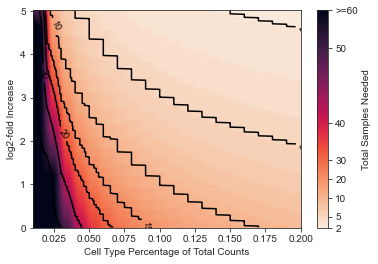

In [13]:
levels=[2,5,10,15,20,30,50,60]
#
contours = plt.contour(X, Y, Z,  levels=levels,  origin="upper", colors='black')
plt.clabel(contours, contours.levels, inline=1, fontsize=9, fmt="%1.0f")


plt.imshow(Z, origin='lower',extent=[ 0.01,0.2,0.0,5.01],
           cmap=sns.cm.rocket_r, aspect='auto')

cbar = plt.colorbar(label="Total Samples Needed",ticks=[2,5,10,15,20,30,50,60])
cbar.ax.set_yticklabels(["2", "5", "10","20","30","40", "50", ">=60"]) 

plt.xlabel("Cell Type Percentage of Total Counts")
plt.ylabel("log2-fold Increase")
# plt.savefig("power_analysis_logit_reg_FDR005.pdf")

In [14]:
#Power analysis plot

class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s


base_counts = np.arange(0.01, 0.201, 0.01)
log_fold_inc = np.arange(0.01, 5.01, 0.01)

X, Y = np.meshgrid(base_counts, log_fold_inc)
X= X
Z = one_des_mcc(0.8, X, Y,fdr=0.1)

Text(0, 0.5, 'log2-fold Increase')

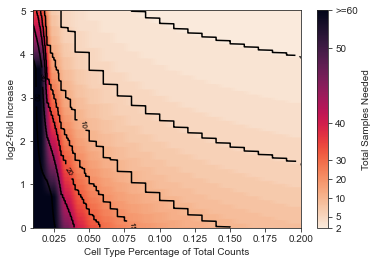

In [15]:
levels=[2,5,10,15,20,30,50,60]
#
contours = plt.contour(X, Y, Z,  levels=levels,  origin="upper", colors='black')
plt.clabel(contours, contours.levels, inline=True, fontsize=8, fmt="%1.0f")


plt.imshow(Z, origin='lower',extent=[ 0.01,0.2,0.0,5.01],
           cmap=sns.cm.rocket_r, aspect='auto')

cbar = plt.colorbar(label="Total Samples Needed",ticks=[2,5,10,15,20,30,50,60])
cbar.ax.set_yticklabels(["2", "5", "10","20","30","40", "50", ">=60"]) 
plt.xlabel("Cell Type Percentage of Total Counts")
plt.ylabel("log2-fold Increase")
# plt.savefig("power_analysis_logit_reg_FDR01.pdf")

In [ ]:
#Power analysis plot

class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s


base_counts = np.arange(0.01, 0.201, 0.01)
log_fold_inc = np.arange(0.01, 5.01, 0.01)

X, Y = np.meshgrid(base_counts, log_fold_inc)
X= X
Z = one_des_mcc(0.8, X, Y,fdr=0.2)

Text(0, 0.5, 'log2-fold Increase')

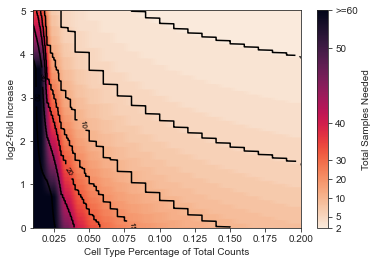

In [16]:
levels=[2,5,10,15,20,30,50,60]
#
contours = plt.contour(X, Y, Z,  levels=levels,  origin="upper", colors='black')
plt.clabel(contours, contours.levels, inline=True, fontsize=8, fmt="%1.0f")


plt.imshow(Z, origin='lower',extent=[ 0.01,0.2,0.0,5.01],
           cmap=sns.cm.rocket_r, aspect='auto')

cbar = plt.colorbar(label="Total Samples Needed",ticks=[2,5,10,15,20,30,50,60])
cbar.ax.set_yticklabels(["2", "5", "10","20","30","40", "50", ">=60"]) 

plt.xlabel("Cell Type Percentage of Total Counts")
plt.ylabel("log2-fold Increase")
# plt.savefig("power_analysis_logit_reg_FDR02.pdf")

In [17]:
"""
                    (Intercept)                   log.increase 
                   0.137392325                    0.070745855 
        log.total:log.increase    log.total:log.fold.increase 
                   0.012170696                    0.008933045 
log.increase:log.fold.increase 
                   0.004218408
"""


#python cell
from matplotlib import cm

def one_des_mcc(power, base, lf_inc, fdr=0.05):
    """ 
                        (Intercept)                   log.increase 
                       0.137392325                    0.070745855 
            log.total:log.increase    log.total:log.fold.increase 
                       0.012170696                    0.008933045 
    log.increase:log.fold.increase 
                       0.004218408
    """
    
    # parameter sets
    param_sets = {"0.2":{"inter":0.137392325, "log_total":-0.11288208 , "log_inc": 0.06954384 , "log_fold_inc":0.0, "log_total_log_inc": 0.05325303, "log_inc_log_fold_inc":0.01634580},
                  "0.1":{"inter":-0.11950939, "log_total":-0.19988348, "log_inc":0.0, "log_fold_inc":-0.15633159, "log_total_log_inc":0.07211883, "log_inc_log_fold_inc":0.04186542},
                  "0.05":{"inter":-0.14044029, "log_total":-0.16678069, "log_inc":0.0, "log_fold_inc":-0.22374997, "log_total_log_inc":0.06541749, "log_inc_log_fold_inc":0.05286727}
                 }
    try:
        prms = param_sets[str(round(fdr,2))]
        tpr = power
        #base = base
        inc = 5000*base
        log_inc = np.log(inc)

        # invers regress sample size
        log_samples = - (prms["inter"] + prms["log_inc"]*lf_inc +prms["log_fold_inc"]*lf_inc +prms["log_inc_log_fold_inc"]*lf_inc*log_inc - tpr)/(prms["log_total_log_inc"]*log_inc+ prms["log_total"])
        nof_sample = np.exp(log_samples)
        nof_sample[nof_sample<= 0.0] = 1
        nof_sample[nof_sample > 60] = 60
        nof_sample = np.nan_to_num(nof_sample, posinf=80, neginf=-50)
        return np.round(nof_sample)
    except:
        raise TypeError("Only FDRs of 0.5, 0.1, 0.2 allowed")


In [18]:
## FDR 0.05

In [19]:
from matplotlib import cm

def one_des_mcc(power, base, lf_inc):
    """ 
    calculates the number of required samples for 
    fixed MCC base increase and log-fold change using the fitted linear model
    
    log_total_sample = -(a + b2 x2 + b4 x2 x3 - y)/(b1 + b3 x3)
    
      nvmax     RMSE  Rsquared      MAE     RMSESD  RsquaredSD      MAESD
1     1 5.711239 0.5986302 4.413231 0.10979276 0.015850151 0.09833272
2     2 4.567415 0.7432891 3.667774 0.07175505 0.008376705 0.06114342
3     3 4.362100 0.7658576 3.535627 0.07484678 0.008446238 0.06095027
4     4 4.282486 0.7743372 3.464744 0.07708568 0.008522654 0.05879779

                    (Intercept)                      log.total 
                   -14.2513711                     -3.6318700 
             log.fold.increase         log.total:log.increase 
                    -3.8218517                      1.4607689 
log.increase:log.fold.increase 
                     0.9887077
                     
                     TODO
                     
    """
    
    # scale and transform input features
    tpr = np.log((power+0.00001)/(1-power+0.00001))
    #base = base
    inc = 5000*base
    log_inc = np.log(inc)
    
    # invers regress sample size
    log_samples = - (-13.8759786 + -2.3131486*lf_inc + 0.7344426*lf_inc*log_inc - tpr)/(1.6059183*log_inc+ -4.2360722)
    nof_sample = np.exp(log_samples)
    nof_sample[nof_sample<= 0.0] = 1
    nof_sample[nof_sample > 50] = 50
    nof_sample = np.nan_to_num(nof_sample, posinf=80, neginf=-50)
    return np.round(nof_sample) 

In [20]:
#Power analysis plot

class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s


base_counts = np.arange(0.01, 0.201, 0.01)
log_fold_inc = np.arange(0.01, 5.01, 0.01)

X, Y = np.meshgrid(base_counts, log_fold_inc)
X= X
Z = one_des_mcc(0.8, X, Y)